In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [2]:
df = pd.read_csv('df_features.csv')
print(df.shape)
df.head()

(200, 67)


,file_name,zcr_mean,zcr_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_2_mean,spectral_bandwidth_2_std,spectral_bandwidth_3_mean,spectral_bandwidth_3_std,spectral_bandwidth_4_mean,...,mfccs_11_std,mfccs_12_std,mfccs_13_std,mfccs_14_std,mfccs_15_std,mfccs_16_std,mfccs_17_std,mfccs_18_std,mfccs_19_std,mfccs_20_std
0,96_unhealthy.wav,0.098,0.029,1963.398,429.247,2065.324,291.792,2529.911,246.988,2969.965,...,6.605,6.183,5.901,5.394,6.599,5.817,6.265,5.659,6.259,5.632
1,110_healthy.wav,0.173,0.066,3253.160,718.194,3028.504,318.466,3474.075,249.361,3877.095,...,8.478,6.507,6.880,6.243,6.538,6.595,7.043,7.739,7.898,7.800
2,85_unhealthy.wav,0.121,0.061,2183.576,732.564,2060.788,332.151,2473.787,291.195,2867.084,...,11.337,10.029,9.587,8.812,9.025,9.653,10.991,11.581,9.163,11.045
3,54_unhealthy.wav,0.132,0.085,2568.334,977.404,2549.717,455.166,3130.641,362.832,3665.620,...,8.370,9.574,9.234,9.064,7.334,8.153,6.235,7.513,8.962,6.941
4,34_unhealthy.wav,0.135,0.039,2769.793,529.538,2649.070,287.417,3119.832,225.332,3553.303,...,8.563,6.060,6.297,5.949,6.653,5.654,5.766,6.169,6.136,8.071


In [3]:
label_dict = {'healthy':0,
              'unhealthy':1,
             }

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_')[1]])
df.head()

,file_name,zcr_mean,zcr_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_2_mean,spectral_bandwidth_2_std,spectral_bandwidth_3_mean,spectral_bandwidth_3_std,spectral_bandwidth_4_mean,...,mfccs_12_std,mfccs_13_std,mfccs_14_std,mfccs_15_std,mfccs_16_std,mfccs_17_std,mfccs_18_std,mfccs_19_std,mfccs_20_std,label
0,96_unhealthy.wav,0.301587,0.088710,0.268691,0.152868,0.256771,0.252599,0.297289,0.210060,0.292650,...,0.159620,0.089466,0.027172,0.135659,0.101706,0.190596,0.106306,0.157593,0.124664,1
1,110_healthy.wav,0.698413,0.387097,0.698370,0.360898,0.752055,0.288980,0.789757,0.213978,0.788955,...,0.193780,0.182544,0.076151,0.131002,0.152170,0.260674,0.282353,0.289984,0.306544,0
2,85_unhealthy.wav,0.423280,0.346774,0.342042,0.371244,0.254438,0.307645,0.268016,0.283048,0.236362,...,0.565103,0.439913,0.224357,0.320864,0.350522,0.616285,0.607533,0.392165,0.578775,1
3,54_unhealthy.wav,0.481481,0.540323,0.470223,0.547518,0.505854,0.475425,0.610625,0.401324,0.673254,...,0.517132,0.406351,0.238895,0.191770,0.253227,0.187894,0.263225,0.375929,0.234480,1
4,34_unhealthy.wav,0.497354,0.169355,0.537338,0.225073,0.556943,0.246632,0.604987,0.174305,0.611803,...,0.146653,0.127115,0.059190,0.139782,0.091133,0.145649,0.149471,0.147658,0.329279,1


In [4]:
with open('pred_probas/testset_filenames.txt', 'r') as f:
    test_files = f.readlines()
test_files = [t.strip() for t in test_files]

indices = []
for t in test_files:
    indices.append(df[df.file_name==t].index[0])

df_test = df.iloc[indices,:]
df.drop(labels=indices, inplace=True)

cl_weight = dict(pd.Series(df['label']).value_counts(normalize=True))

x_train = df[df.columns[1:-1]]
x_test = df_test[df.columns[1:-1]]
y_train = df['label']
y_test = df_test['label']

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

Test Set Accuracy =  1.00
Test Set F-score =  1.00
ROC AUC = 1.000
Confusion matrix, without normalization
[[6 0]
 [0 4]]
CPU times: user 209 ms, sys: 50.9 ms, total: 260 ms
Wall time: 850 ms


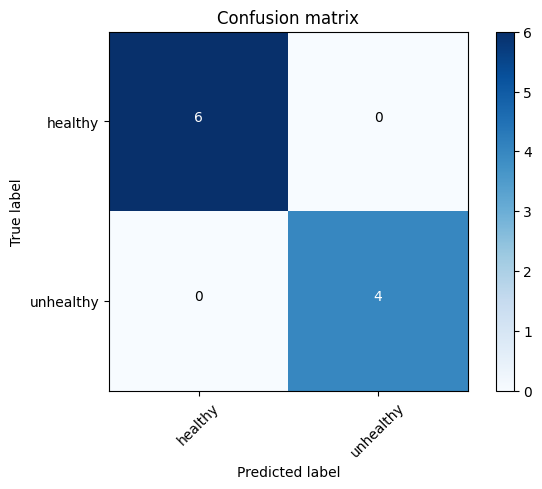

In [6]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  1.00
Test Set F-score =  1.00
ROC AUC = 1.000
Confusion matrix, without normalization
[[6 0]
 [0 4]]
CPU times: user 1.7 s, sys: 38.4 ms, total: 1.74 s
Wall time: 1.88 s


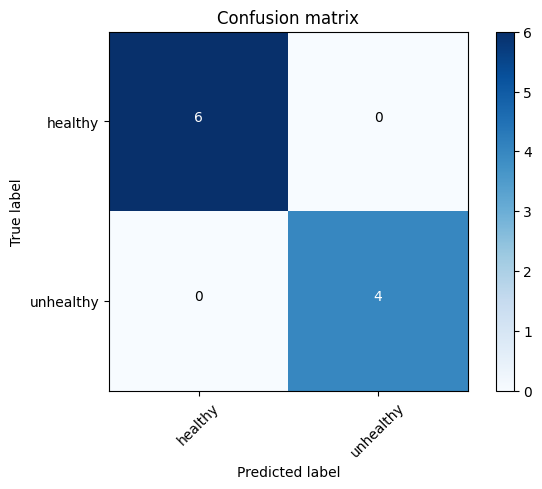

In [7]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:54:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  1.00
Test Set F-score =  1.00
ROC AUC = 1.000
Confusion matrix, without normalization
[[6 0]
 [0 4]]
CPU times: user 3.72 s, sys: 60.5 ms, total: 3.78 s
Wall time: 3.41 s


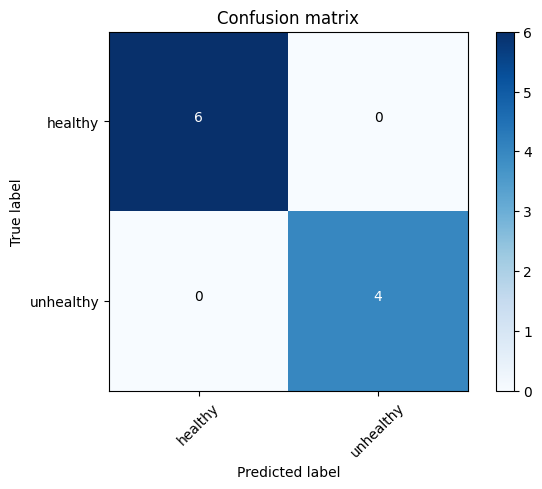

In [8]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob',
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  1.00
Test Set F-score =  1.00
ROC AUC = 1.000
Confusion matrix, without normalization
[[6 0]
 [0 4]]
CPU times: user 167 ms, sys: 15.6 ms, total: 183 ms
Wall time: 176 ms


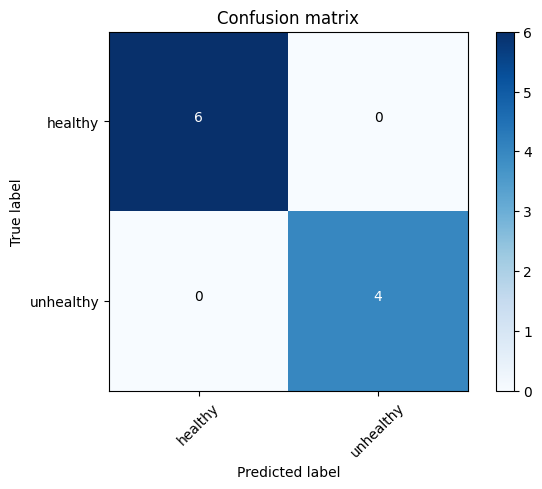

In [9]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, class_weight=cl_weight, kernel='rbf')
svm_classifier.fit(x_train, y_train)

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/svm_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

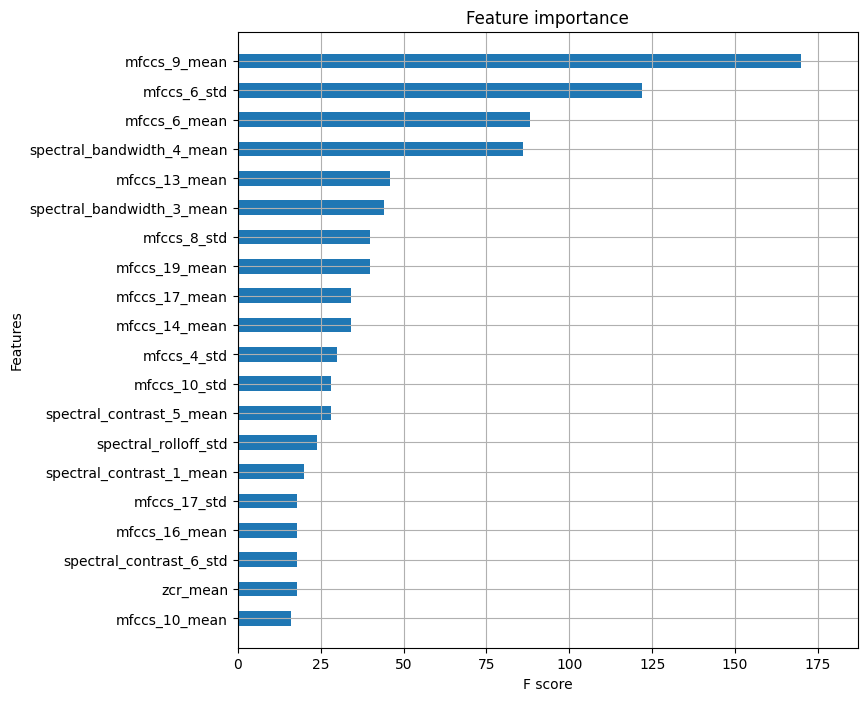

In [10]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)

In [11]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.00129205, 0.        , 0.        , 0.        , 0.        ,
       0.0634138 , 0.02847655, 0.02472695, 0.17199099, 0.        ,
       0.02294176, 0.04626561, 0.01763039, 0.        , 0.00303677,
       0.05277564, 0.00963685, 0.02693949, 0.00514863, 0.        ,
       0.        , 0.00510997, 0.00081574, 0.01532295, 0.        ,
       0.00450367, 0.02227663, 0.        , 0.00877995, 0.01917928,
       0.00113659, 0.05482278, 0.        , 0.01753468, 0.11095476,
       0.00350124, 0.00929648, 0.00833015, 0.0163166 , 0.01449944,
       0.        , 0.00581152, 0.00879925, 0.        , 0.00701293,
       0.01649522, 0.        , 0.        , 0.        , 0.00644048,
       0.00971432, 0.05133895, 0.00850485, 0.01893242, 0.00996592,
       0.03222359, 0.00134297, 0.01785092, 0.00308476, 0.00133428,
       0.        , 0.01390508, 0.00058613, 0.        , 0.        ,
       0.        ], dtype=float32)

In [12]:
top_n = [10, 20, 30]
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))

    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)

    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob',
                                       n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)
    print()

Stats for top 10 features:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:55:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  1.00
Test Set F-score =  1.00
ROC AUC = 1.000

Stats for top 20 features:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:55:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  1.00
Test Set F-score =  1.00
ROC AUC = 1.000

Stats for top 30 features:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:55:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  1.00
Test Set F-score =  1.00
ROC AUC = 1.000



Test Set Accuracy =  1.00
Test Set F-score =  1.00
ROC AUC = 1.000
Confusion matrix, without normalization
[[6 0]
 [0 4]]


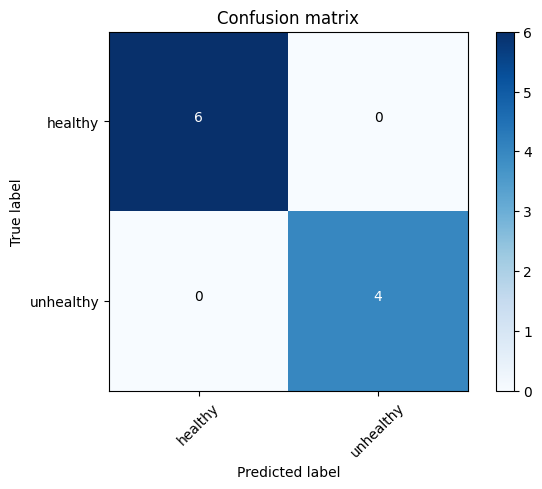

In [13]:
with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)

with open('pred_probas/vgg_fine_tuning.pkl', 'rb') as f:
    vgg_pred_probs = pickle.load(f)

n_samples = np.min([len(xgb_pred_probs), len(vgg_pred_probs)])

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs[:n_samples] + vgg_pred_probs[:n_samples])/2.0

# Show metrics
display_results(y_test[:n_samples], ensemble_pred_probs)

In [14]:
def plot_roc_curves(y_true, pred_probs, label_dict):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    NUM_CLASSES = len(label_dict)
    one_hot_true = one_hot_encoder(y_true, len(y_true), NUM_CLASSES)
    for i in range(len(label_dict)):
        fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

<ipython-input-14-9e246544ebe7>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
<ipython-input-14-9e246544ebe7>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
<ipython-input-14-9e246544ebe7>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


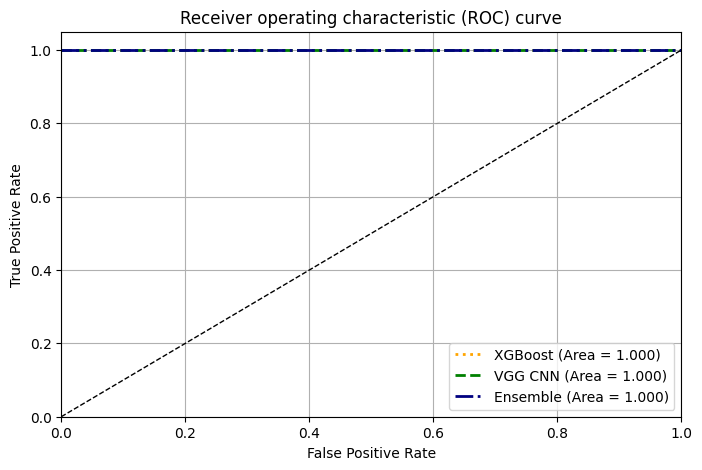

In [15]:
plt.figure(figsize=(8,5))

plt.title('Macro-average ROC curves')

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], xgb_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='XGBoost (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='orange', linestyle=':', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], vgg_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='VGG CNN (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='green', linestyle='--', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], ensemble_pred_probs[:n_samples]
                                    , label_dict)
plt.plot(fpr, tpr,
         label='Ensemble (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='navy', linestyle='-.', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
# plt.savefig('plots/roc-curve.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:57:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  0.90
Test Set F-score =  0.89
ROC AUC = 0.917
Confusion matrix, without normalization
[[6 0]
 [1 3]]
CPU times: user 1.41 s, sys: 43.7 ms, total: 1.45 s
Wall time: 1.21 s


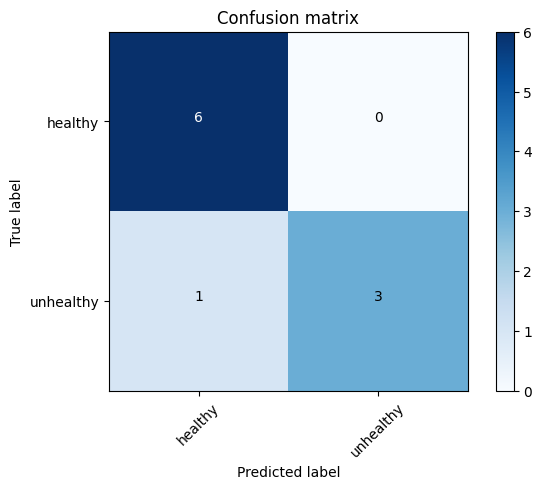

In [16]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob',
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,:9], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,:9])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_time_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:57:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  0.90
Test Set F-score =  0.90
ROC AUC = 0.958
Confusion matrix, without normalization
[[5 1]
 [0 4]]
CPU times: user 7.44 s, sys: 43.2 ms, total: 7.48 s
Wall time: 13 s


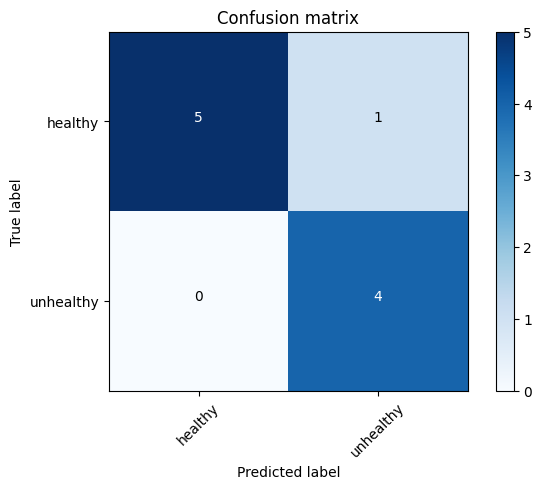

In [17]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob',
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,9:], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,9:])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_freq_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [18]:
!zip -r pred_probas.zip pred_probas

  adding: pred_probas/ (stored 0%)
  adding: pred_probas/lr_classifier.pkl (deflated 3%)
  adding: pred_probas/xgb_classifier_freq_domain.pkl (deflated 7%)
  adding: pred_probas/svm_classifier.pkl (deflated 3%)
  adding: pred_probas/testset_filenames.txt (deflated 66%)
  adding: pred_probas/rf_classifier.pkl (deflated 3%)
  adding: pred_probas/vgg_fine_tuning.pkl (deflated 7%)
  adding: pred_probas/xgb_classifier.pkl (deflated 7%)
  adding: pred_probas/xgb_classifier_time_domain.pkl (deflated 7%)
